In [22]:
import sfs
import sys
sys.path.insert(0, '../../main')
from loudspeakers import *
from regions_interest import *
from optimization import *
from post_processing import *
from utils_general import *
from utils_nfchoa import *
from green_function import *

In [8]:
def get_solution(method, source, loudspeakers, region_of_interest):
    if method in {'NFC-HOA_SFS', 'WFS'}:
        omega = 2 * np.pi * source.frq[0]
        array = sfs.array.circular(loudspeakers.n_loud, loudspeakers.diam / 2)
        sfs_position = np.append(source.pos - loudspeakers.diam / 2 * np.ones(2), 0)
        if method == 'WFS':
            if np.linalg.norm(sfs_position) >= loudspeakers.diam / 2:
                d, s_wfs, ss_wfs = sfs.fd.wfs.point_25d(omega, array.x, array.n, sfs_position,
                                                        xref=np.asarray([0, 0, 0]))
            else:
                d, s_wfs, ss_wfs = sfs.fd.wfs.focused_25d(omega, array.x, array.n, sfs_position, -sfs_position,
                                                          xref=np.asarray([0, 0, 0]))
            d *= s_wfs
        else:
            d, s_hoa, ss_hoa = sfs.fd.nfchoa.point_25d(omega, array.x, loudspeakers.diam / 2, sfs_position)
        d = np.expand_dims(d * np.pi * loudspeakers.diam * source.int[0] / loudspeakers.n_loud, axis=0)
        region_of_interest.initialize()

    elif method == 'SWEET':
        opt_sweet = SweetOptimization(loudspeakers, source, region_of_interest, truncation=0, penalty_norm=1,
                                      lamb=10 ** (-10))
        d, d_sweet_best = opt_sweet.minimize(show=False, epsilon_sequence=99)

    elif method == 'L2-PMM':
        opt_L2 = LpqOptimization(loudspeakers, source, region_of_interest, truncation=0,
                                 penalty_norm=1, lamb=0)
        d = opt_L2.minimize(p=2, q=2, weighted=False, constraint_type=None, show=False)

    elif method == 'NFC-HOA_MANUAL':
        sfs_normalization = np.pi * loudspeakers.diam * source.int[0] / loudspeakers.n_loud
        centered_position = position - np.ones(2) * loudspeakers.diam / 2
        a_l = np.linspace(0, 2 * np.pi, num=loudspeakers.n_loud, endpoint=False)
        r_l = loudspeakers.diam / 2
        a_s = np.arctan2(centered_position[1], centered_position[0])
        r_s = np.linalg.norm(centered_position)
        f = source.frq[0]
        d = np.expand_dims(sfs_normalization * nfchoa_25d(a_s, r_s, a_l, r_l, f), axis=0)
        region_of_interest.initialize()

    else:
        raise TypeError
    return d

In [9]:
radius = 2.5
lim = np.asarray([radius, 2 * radius])
frequency = 343
n_loudspeakers = 20
position_y_map = {'NF': 3 * radius,
                  'FS': 4 / 3 * radius
                  }

In [11]:
method = 'L2-PMM'   # Options: SWEET, L2-PMM, WFS, NFC-HOA_SFS, NFC-HOA_MANUAL
instance = 'FS' # Options: NF (near field), FS (focus source)

In [12]:
position = np.asarray([radius, position_y_map[instance]])
normalization = np.linalg.norm(position - lim) if position[1] > 2 * radius + 1 else 1
intensity = normalization * pressure(60)

region_of_interest = CircleRegion(2500, 2 * radius, ratio=0.99)

green_function = HRTF(frequency, reference=position) if method == 'SWEET' else Monopole(frequency)

loudspeakers = CircleLoudspeakers(n_loud=n_loudspeakers,
                                    diameter=2 * radius,
                                    frequencies=frequency,
                                    green_function=green_function)

source = Source(frequencies=frequency,
                positions=position,
                intensities=intensity,
                green_function=green_function)

In [13]:
print('Computing soultion. This might take a few minutes...')

solution = get_solution(method=method,
                        source=source,
                        loudspeakers=loudspeakers,
                        region_of_interest=region_of_interest)

Computing soultion. This might take a few minutes...


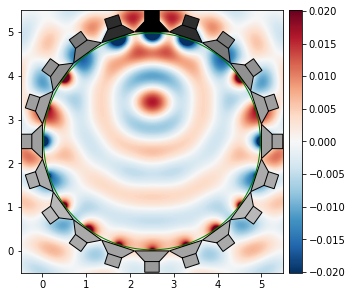

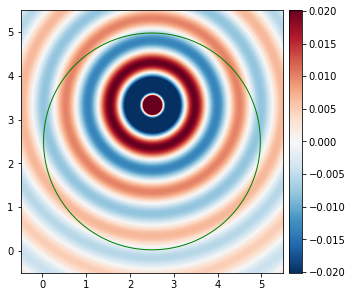

In [14]:
n_side_points = 300
green_function_pp = Monopole(frequency)
source.GF = green_function_pp
loudspeakers.GF = green_function_pp
pp = PostProcessing(solution, source, loudspeakers, region_of_interest,
                    green_function=green_function_pp,
                    n_points=n_side_points ** 2,
                    r=1.2)
u = pp.u(mask=False)
u0 = pp.u0(mask=False)

Time A 0.04597902297973633


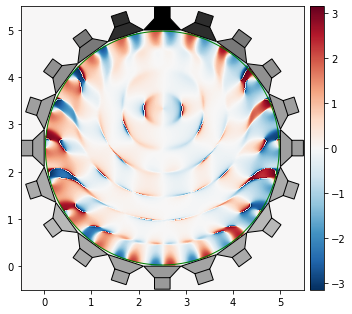

In [17]:
n_side_points = 100

print('Computing HRTFs. This might take a few minutes...')
green_function_pp = HRTF(frequency, reference=position)
source.GF = green_function_pp
loudspeakers.GF = green_function_pp

pp = PostProcessing(solution, source, loudspeakers, region_of_interest,
                    green_function=green_function_pp,
                    n_points=n_side_points ** 2,
                    r=1.2)

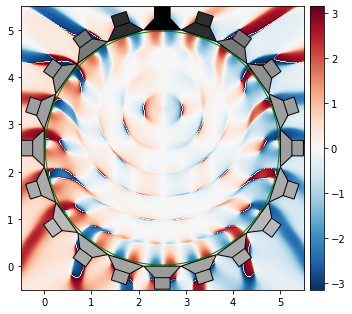

In [25]:
pp.interaural_difference(mask=False,
                         regions=True, 
                         loudspeakers=True,
                         object_name='u',
                         interaural_name='IPD')

/Users/pedro/Desktop/SWEET/sweet-sps/experiments/taslp2022/../../main/post_processing.py:534: RuntimeWarning: invalid value encountered in remainder
  cartesi_error = np.abs((array - array_reference + 180) % 360 - 180)


Sweet spot L2-PMM_FS_localization_error: 0.4431818181818182


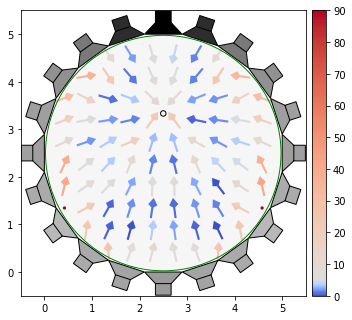

The size of the Localization Sweet Spot is 0.4431818181818182 times the size of Omega.


In [27]:
mat = scipy.io.loadmat(f'data/localization_estimations/{method}_{instance}.mat')
localization_u = mat['localization_u']

mat_reference = scipy.io.loadmat(f'data/localization_estimations/u0_{instance}.mat')       
localization_u0 = mat_reference['localization_u0']

d = scipy.io.loadmat(f'data/solutions/{method}_{instance}.mat')['solution']

LSS = pp.external_plot(array=localization_u,
                       array_reference=localization_u0,
                       plot_type='vector',
                       vmax=90,
                       position_reference=position,
                       mask=True,
                       regions=True,
                       loudspeakers=True,
                       name=f'{method}_{instance}_localization_error')
print(f'The size of the Localization Sweet Spot is {LSS} times the size of Omega.')